# Total days of smoke PM vs total PM

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
pm25 = xr.open_dataset("data/wc/PM25_daily_CensusTract_2005_2020_WesternUS.nc")

In [ ]:
pm25

In [ ]:
df_pm25 = pm25[["MEAN_NONE_SPATIAL_NEIGHBORS"]].to_dataframe()
df_pm25 = df_pm25.rename(columns={"MEAN_NONE_SPATIAL_NEIGHBORS": "pm25"})
df_pm25 = df_pm25.reset_index()

In [ ]:
df_pm25 = df_pm25[["time", "locations", "pm25"]]
df_pm25.head()

## Time preselection

In [ ]:
df_pm25['time'] = pd.to_datetime(df_pm25['time'])
df_pm25 = df_pm25[df_pm25['time'] >= '2006-01-01']
df_pm25 = df_pm25[df_pm25['time'] <= '2020-12-31']

## Get location ID

In [ ]:
locs = pm25[["location_label"]].to_dataframe()

In [ ]:
len(df_pm25)

In [ ]:
df = df_pm25.merge(locs, left_on='locations', right_on="labelDim", how='left')

In [ ]:
len(df)

## Get metrics

In [ ]:
df = df[["time","location_label","pm25"]]
df = df.groupby(by=["time","location_label"]).first().reset_index()
df.head()

In [12]:
df['polluted_over_zero'] = np.where(df['pm25'] > 0.0, True, False)
df['polluted_over_five'] = np.where(df['pm25'] > 5.0, True, False)
df['polluted_over_35'] = np.where(df['pm25'] >= 35, True, False)

In [14]:
data.time.min()

Timestamp('2006-01-01 00:00:00')

In [15]:
data.time.max()

Timestamp('2020-12-14 00:00:00')

In [ ]:
df.to_parquet("outputs/total_total_pm25_pollution.parquet")

## Plots

In [5]:
df = pd.read_parquet("outputs/total_total_pm25_pollution.parquet")

In [6]:
grouped = df.groupby("location_label")[["polluted_over_zero","polluted_over_five","polluted_over_35"]].sum()

In [7]:
df = grouped.reset_index()

In [8]:
gdf = gpd.read_file('data/WesternUSCensusTract/CensusTract2020_WesternUS.shp')
data = gdf.merge(df, left_on="FIPS", right_on="location_label")

In [9]:
import textwrap

In [19]:
titles = {
    'polluted_over_zero': "non zero",
    'polluted_over_five': "over $5ug/m^3$",
    'polluted_over_35': "over $35ug/m^3$"
}

In [11]:
import helper_400
helper_400.set_sns_style()

<Figure size 800x600 with 0 Axes>

In [12]:
titles.keys()

dict_keys(['polluted_over_zero', 'polluted_over_five', 'polluted_over_35'])

In [14]:
plt.rcParams["font.family"] = "Times New Roman"

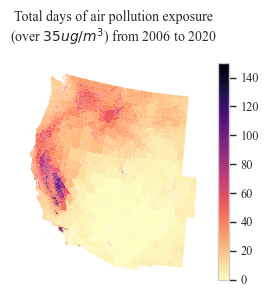

In [21]:
for x in ['polluted_over_35']: # titles.keys()[1]:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    vmax = data[x].max()
    vmin = data[x].min()
    vmax = 0.7 * vmax
    cmap = "magma_r"
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    data.plot(
        column=x, 
        ax=ax, 
        legend=True, 
        vmax=150,
        #vmin=vmin,
        linewidth=0, 
        cmap=cmap, 
        missing_kwds={"color": "lightgrey"},
        )
   
    
    title_text = "Total days of air pollution exposure ("+ titles[x]+ ") from 2006 to 2020"
    wrapped_title = textwrap.fill(title_text, 40)
    ax.set_title(wrapped_title, fontsize=10)
    ax.set_axis_off()

    plt.tight_layout()
    plt.savefig("figures/centract_hotspots_wc_total_pm25_air"+x+".png", dpi=300, bbox_inches='tight')
    plt.show()